# Demo - Conditional Gaussianization Flow (Classification)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [203]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.preprocessing import label_binarize, LabelBinarizer, MultiLabelBinarizer
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    noise: float = 0.05,
) -> Iterator[Batch]:
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=seed)
    #     X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    #     X, y = datasets.make_multilabel_classification(
    #         n_samples=n_samples,
    #         n_features=2,
    #         n_classes=3,
    #         random_state=seed,
    #         allow_unlabeled=False,
    #     )

    #     print(y.shape)
    #     y = label_binarize(y, classes=np.unique(y))
    #     print(y.shape)

    if y.ndim < 2:
        y = label_binarize(y, classes=np.unique(y))
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [204]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 5_000
n_train = 5_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123, noise=0.1)

# demo batch
init_X, init_Y = next(init_ds)
init_X.shape, init_Y.shape

((2000, 2), (2000, 3))

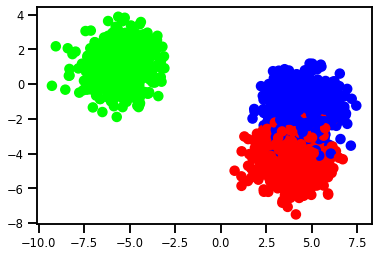

In [205]:
fig, ax = plt.subplots()

ax.scatter(init_X[:, 0], init_X[:, 1], c=init_Y)
plt.show()

In [206]:
# fig, ax = plt.subplots()

# zero_class = np.where(init_Y[:, 0])
# one_class = np.where(init_Y[:, 1])
# two_class = np.where(init_Y[:, 2])
# ax.scatter(init_X[zero_class, 0], init_X[zero_class, 1], c="red")
# ax.scatter(init_X[one_class, 0], init_X[one_class, 1], c="blue")
# ax.scatter(init_X[two_class, 0], init_X[two_class, 1], c="green")


# plt.show()

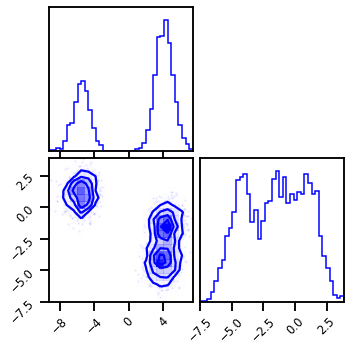

In [207]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

## DataLoader

In [208]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, rng=None) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    return inputs, labels

## Model

In [211]:
from rbig_jax.models.gaussflow import init_default_gf_model

# initialization data
n_init_samples = 10_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)
# demo batch
init_ds = next(init_ds)
X_init, Y_init = prepare_data(init_ds, None)
X_init, Y_init = np.array(X_init), np.array(Y_init)


# marginal uniformization
mixture = "gaussian"
n_components = 10
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "gaussian"

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 4

In [212]:
# init model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 4 | Layer 11: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


### Plot Initial Layers

In [213]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X_init)

CPU times: user 593 ms, sys: 55.1 ms, total: 648 ms
Wall time: 539 ms


DeviceArray(4.2793174, dtype=float32)

### Conditional Model

In [214]:
from distrax._src.distributions.log_stddev_normal import LogStddevNormal
from typing import Sequence, Callable, Tuple
import flax
from flax import linen as nn
from flax import struct


class ExplicitMLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
        # for single submodules, we would just write:
        # self.layer1 = nn.Dense(self, feat1)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x

In [215]:
from rbig_jax.models.conditional import ExplicitMLP

# create model
input_features = X_init.shape[1]
# model = nn.Dense(features=input_features * 2)
model = ExplicitMLP(features=[20, 2])
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, Y_init)

output = model.apply(params, Y_init)
Y_init.shape, output.shape

((2000, 3), (2000, 2))

In [216]:
from rbig_jax.models.conditional import ConditionalModel

In [217]:
encoder = ConditionalModel(params=params, model=model)

In [218]:
from rbig_jax.models.conditional import ConditionalGaussianizationFlow
from distrax._src.distributions.normal import Normal

cgf_model = ConditionalGaussianizationFlow(
    bijectors=gf_model.bijectors, base_dist=Normal, encoder=encoder
)

### Optimizer

In [219]:
from rbig_jax.training.parametric import init_optimizer

In [220]:
n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam",
    n_epochs=n_epochs,
    lr=1e-2,
    cosine_decay_steps=n_epochs,
    warmup=None,
    gradient_clip=15.0,
    alpha=1e-1,
)

### Trainer

In [222]:
from rbig_jax.training.parametric import ConditionalGaussFlowTrainer

# initial flow trainer
cnf_trainer = ConditionalGaussFlowTrainer(
    cgf_model, optimizer, n_epochs=n_epochs, prepare_data_fn=prepare_data,
)

In [223]:
train_ds = load_dataset(5_000, 256, 123)

eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = cnf_trainer.train_step(next(train_ds))
        train_loss = output.loss
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = cnf_trainer.validation_step(next(train_ds))
            eval_loss = output.loss
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

cgf_model = output.model

Train Loss: 2.8330 | Valid Loss: 2.8006: 100%|██████████| 5000/5000 [01:01<00:00, 81.56it/s] 


### Results

#### Losses

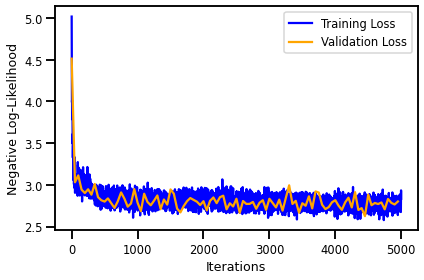

In [224]:
fig, ax = plt.subplots()
ax.plot(
    cnf_trainer.train_epoch, cnf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    cnf_trainer.valid_epoch,
    cnf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Inverse Transform

### Log Probability

#### Plot: Original Density

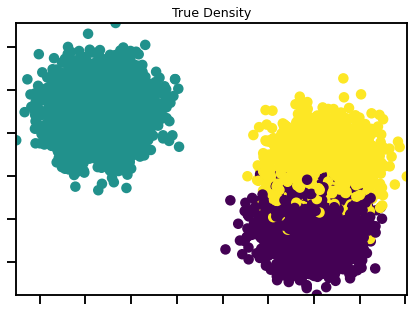

In [226]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 10_000
noise = 0.05
seed = 123
# X_plot, y_plot = datasets.make_moons(
#     n_samples=n_samples, noise=noise, random_state=seed
# )
X_plot, y_plot = datasets.make_blobs(n_samples=n_samples, random_state=seed)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,  # bins=512, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [247]:
jnp.eye(3).shape

(3, 3)

In [248]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X_init[:, 0].min() - buffer, X_init[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X_init[:, 1].min() - buffer, X_init[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

# calculate log probability
X_log_prob_z1 = cgf_model.score_samples(xyinput, jnp.eye(3))
# X_log_prob_z2 = cgf_model.score_samples(xyinput, jnp.array([0,1,0])[None, :])
# X_log_prob_z3 = cgf_model.score_samples(xyinput, jnp.array([0,0,1])[None, :])

TypeError: sub got incompatible shapes for broadcasting: (250000, 2), (3, 1).

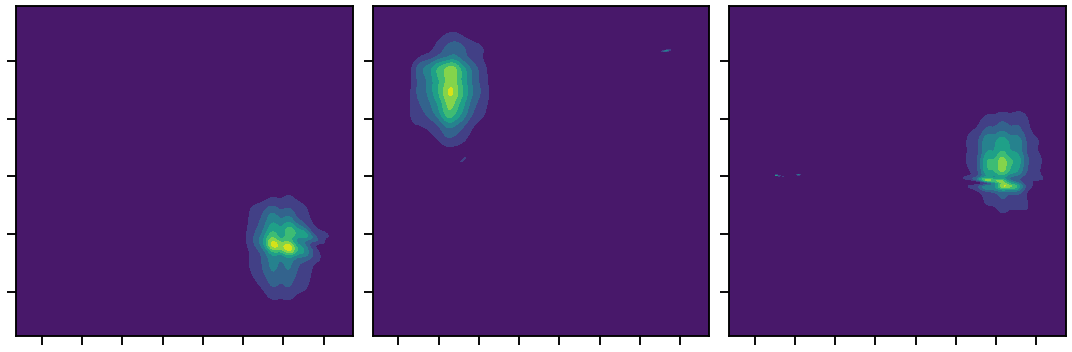

In [234]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].contourf(xgrid, ygrid, np.exp(X_log_prob_z1).reshape(n_grid, n_grid))
ax[1].contourf(xgrid, ygrid, np.exp(X_log_prob_z2).reshape(n_grid, n_grid))
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[2].contourf(xgrid, ygrid, np.exp(X_log_prob_z3).reshape(n_grid, n_grid))
ax[2].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.tight_layout()
plt.show()

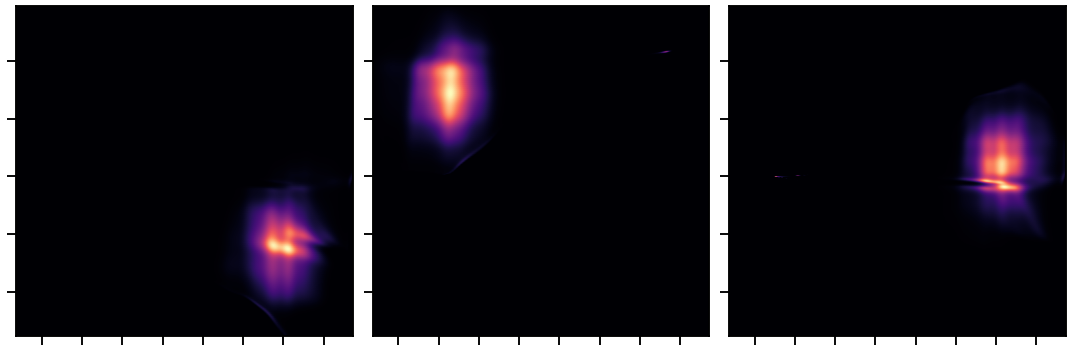

In [242]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# # Estimated Density
# cmap = cm.magma  # "Reds"
# probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

h1 = ax[0].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z1),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
h1 = ax[1].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z2),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
h2 = ax[2].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z3),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[2].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.savefig("demo_cde")
plt.show()

## Sampling

In [27]:
Y_init.shape

(2000, 1)

In [30]:
%%time

n_gen_samples = 10_000

X1_samples = cgf_model.sample(outputs=jnp.zeros(1)[:, None], seed=123, n_samples=n_gen_samples)
X2_samples = cgf_model.sample(outputs=jnp.ones(1)[:, None], seed=123, n_samples=n_gen_samples)

CPU times: user 4min 9s, sys: 12.9 s, total: 4min 22s
Wall time: 39.5 s


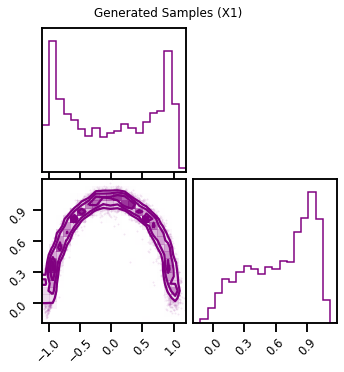

In [31]:
fig2 = corner.corner(np.array(X1_samples), color="purple")
fig2.suptitle("Generated Samples (X1)")
plt.show()

In [ ]:
%%time

X2_samples = cgf_model.sample(outputs=jnp.ones(1)[:, None], seed=123, n_samples=n_gen_samples)

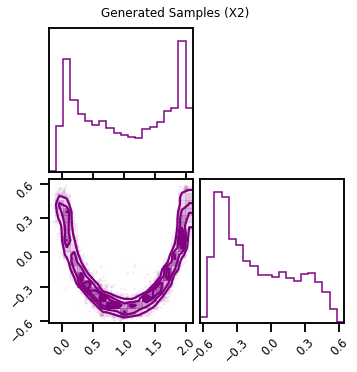

In [32]:
fig2 = corner.corner(np.array(X2_samples), color="purple")
fig2.suptitle("Generated Samples (X2)")
plt.show()

## Saving/Loading Model

#### Save Model

In [24]:
import joblib

joblib.dump(gf_model, "cgf_model.pickle")

['cgf_model.pickle']

#### Load Model

In [25]:
rbig_model_loaded = joblib.load("cgf_model.pickle")